## [ME459] Programming pratice for Students

by jongseob Yun (https://github.com/jseobyun)

# **Dataset connection (from Google drive)**
1. Run this cell and click the link

2. Copy and paste the authorization code

3. Press enter

4. If you success, you can see "Mounted at /content/gdrive/"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


# **Dependency check**

1. All these libraries should be imported for the tutorial

2. If you see some errors, please ask to TA

In [ ]:
import numpy as np
import cv2
import os
import random
import copy
import torch.backends.cudnn as cudnn
import time
import json
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torch.optim
import torchvision.transforms as transforms

import torch
import torch.nn as nn
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls
from torch.nn import functional as F
from torch.nn.parallel.data_parallel import DataParallel

# **Util functions**

1. All functions in this cell are helper functions used in following codes

2. Do not change or revised them

In [ ]:
def world2cam(world_coord, R, t):
    cam_coord = np.dot(R, world_coord.transpose(1,0)).transpose(1,0) + t.reshape(1,3)
    return cam_coord

def cam2pixel(cam_coord, f, c):
    x = cam_coord[:, 0] / (cam_coord[:, 2] + 1e-8) * f[0] + c[0]
    y = cam_coord[:, 1] / (cam_coord[:, 2] + 1e-8) * f[1] + c[1]
    z = cam_coord[:, 2]
    img_coord = np.concatenate((x[:,None], y[:,None], z[:,None]),1)
    return img_coord

def process_bbox(bbox, width, height):
    # sanitize bboxes
    x, y, w, h = bbox
    x1 = np.max((0, x))
    y1 = np.max((0, y))
    x2 = np.min((width - 1, x1 + np.max((0, w - 1))))
    y2 = np.min((height - 1, y1 + np.max((0, h - 1))))
    if w*h > 0 and x2 >= x1 and y2 >= y1:
        bbox = np.array([x1, y1, x2-x1, y2-y1])
    else:
        return None

    # aspect ratio preserving bbox
    w = bbox[2]
    h = bbox[3]
    c_x = bbox[0] + w/2.
    c_y = bbox[1] + h/2.
    aspect_ratio = 1
    if w > aspect_ratio * h:
        h = w / aspect_ratio
    elif w < aspect_ratio * h:
        w = h * aspect_ratio
    bbox[2] = w*1.25
    bbox[3] = h*1.25
    bbox[0] = c_x - bbox[2]/2.
    bbox[1] = c_y - bbox[3]/2.
    return bbox

  # helper functions
def generate_patch_image(cvimg, bbox, scale, rot):
    img = cvimg.copy()
    img_height, img_width, img_channels = img.shape
        
    bb_c_x = float(bbox[0] + 0.5*bbox[2])
    bb_c_y = float(bbox[1] + 0.5*bbox[3])
    bb_width = float(bbox[2])
    bb_height = float(bbox[3])
    
    trans = gen_trans_from_patch_cv(bb_c_x, bb_c_y, bb_width, bb_height, 256, 256, scale, rot, inv=False)
    img_patch = cv2.warpAffine(img, trans, (256, 256), flags=cv2.INTER_LINEAR)

    img_patch = img_patch[:,:,::-1].copy()
    img_patch = img_patch.astype(np.float32)

    return img_patch, trans

def rotate_2d(pt_2d, rot_rad):
    x = pt_2d[0]
    y = pt_2d[1]
    sn, cs = np.sin(rot_rad), np.cos(rot_rad)
    xx = x * cs - y * sn
    yy = x * sn + y * cs
    return np.array([xx, yy], dtype=np.float32)

def gen_trans_from_patch_cv(c_x, c_y, src_width, src_height, dst_width, dst_height, scale, rot, inv=False):
    # augment size with scale
    src_w = src_width * scale
    src_h = src_height * scale
    src_center = np.array([c_x, c_y], dtype=np.float32)

    # augment rotation
    rot_rad = np.pi * rot / 180
    src_downdir = rotate_2d(np.array([0, src_h * 0.5], dtype=np.float32), rot_rad)
    src_rightdir = rotate_2d(np.array([src_w * 0.5, 0], dtype=np.float32), rot_rad)

    dst_w = dst_width
    dst_h = dst_height
    dst_center = np.array([dst_w * 0.5, dst_h * 0.5], dtype=np.float32)
    dst_downdir = np.array([0, dst_h * 0.5], dtype=np.float32)
    dst_rightdir = np.array([dst_w * 0.5, 0], dtype=np.float32)

    src = np.zeros((3, 2), dtype=np.float32)
    src[0, :] = src_center
    src[1, :] = src_center + src_downdir
    src[2, :] = src_center + src_rightdir

    dst = np.zeros((3, 2), dtype=np.float32)
    dst[0, :] = dst_center
    dst[1, :] = dst_center + dst_downdir
    dst[2, :] = dst_center + dst_rightdir

    if inv:
        trans = cv2.getAffineTransform(np.float32(dst), np.float32(src))
    else:
        trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))

    return trans

def trans_point2d(pt_2d, trans):
    src_pt = np.array([pt_2d[0], pt_2d[1], 1.]).T
    dst_pt = np.dot(trans, src_pt)
    return dst_pt[0:2]

def soft_argmax(heatmaps, joint_num=18):

    heatmaps = heatmaps.reshape((-1, joint_num, 64*64*64))
    heatmaps = F.softmax(heatmaps, 2)
    heatmaps = heatmaps.reshape((-1, joint_num, 64, 64, 64))

    accu_x = heatmaps.sum(dim=(2,3))
    accu_y = heatmaps.sum(dim=(2,4))
    accu_z = heatmaps.sum(dim=(3,4))

    accu_x = accu_x * torch.cuda.comm.broadcast(torch.arange(1,64+1).type(torch.cuda.FloatTensor), devices=[accu_x.device.index])[0]
    accu_y = accu_y * torch.cuda.comm.broadcast(torch.arange(1,64+1).type(torch.cuda.FloatTensor), devices=[accu_y.device.index])[0]
    accu_z = accu_z * torch.cuda.comm.broadcast(torch.arange(1,64+1).type(torch.cuda.FloatTensor), devices=[accu_z.device.index])[0]

    accu_x = accu_x.sum(dim=2, keepdim=True) -1
    accu_y = accu_y.sum(dim=2, keepdim=True) -1
    accu_z = accu_z.sum(dim=2, keepdim=True) -1

    coord_out = torch.cat((accu_x, accu_y, accu_z), dim=2)

    return coord_out


def vis_keypoints(img, kps, kp_thresh=0.4, alpha=1):
    kps_lines = ( (0, 7), (7, 8), (8, 9), (9, 10), (8, 11), (11, 12), (12, 13), (8, 14), (14, 15), (15, 16), (0, 1), (1, 2), (2, 3), (0, 4), (4, 5), (5, 6) )
    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kps_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)

    # Draw the keypoints.

    for l in range(len(kps_lines)):
        i1 = kps_lines[l][0]
        i2 = kps_lines[l][1]

        p1 = kps[0, i1].astype(np.int32), kps[1, i1].astype(np.int32)
        p2 = kps[0, i2].astype(np.int32), kps[1, i2].astype(np.int32)

        if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
            cv2.line(
                kp_mask, p1, p2,
                color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        if kps[2, i2] > kp_thresh:
            cv2.circle(
                kp_mask, p2,
                radius=3, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)



# **Data preprocessing & Data loading**

1. Human3.6M dataset consists of images(1000x1000x3)  and 3D body joints

2. I crop the images using the bounding box and convert them to (256x256x3) maintaining the aspect ratio

3. I convert 3D body joitns to 2D body joints by camera projection

In [ ]:
data_loc = '/content/gdrive/My Drive'
class Human36M:
    def __init__(self, data_split):
        self.data_split = data_split
        self.img_dir = os.path.join(data_loc, 'HUMAN36M', 'images')
        self.annot_path = os.path.join(data_loc, 'HUMAN36M', 'annotations')                
        self.joints_name = ('Pelvis', 'R_Hip', 'R_Knee', 'R_Ankle', 'L_Hip', 'L_Knee', 'L_Ankle', 'Torso', 'Neck', 'Nose', 'Head', 'L_Shoulder', 'L_Elbow', 'L_Wrist', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'Thorax')
        self.action_name = ['Directions', 'Discussion', 'Eating', 'Greeting', 'Phoning', 'Posing', 'Purchases', 'Sitting', 'SittingDown', 'Smoking', 'Photo', 'Waiting', 'Walking', 'WalkDog', 'WalkTogether']
        self.root_idx = self.joints_name.index('Pelvis')
        self.lshoulder_idx = self.joints_name.index('L_Shoulder')
        self.rshoulder_idx = self.joints_name.index('R_Shoulder')        
        self.data = self.load_data()

    def get_subsampling_ratio(self):
        if self.data_split == 'train':
            return 5
        elif self.data_split == 'test':
            return 64
        else:
            assert 0, print('Unknown subset')

    def get_subject(self):
        if self.data_split == 'train':
            subject = [11] # train set and test set should not be same but we use same data only for the tutorial
        elif self.data_split == 'test':
            subject = [11]          
        return subject
    
    def add_thorax(self, joint_coord):
        thorax = (joint_coord[self.lshoulder_idx, :] + joint_coord[self.rshoulder_idx, :]) * 0.5
        thorax = thorax.reshape((1, 3))
        joint_coord = np.concatenate((joint_coord, thorax), axis=0)
        return joint_coord

    def load_data(self):
        print('Load data of H36M')
        subject_list = self.get_subject()
        sampling_ratio = self.get_subsampling_ratio()
        
        # aggregate annotations from each subject
        db = COCO()
        cameras = {}
        joints = {}
        for subject in subject_list:
            # data load
            with open(os.path.join(self.annot_path, 'Human36M_subject' + str(subject) + '_data_new.json'),'r') as f:
                annot = json.load(f)
            if len(db.dataset) == 0:
                for k,v in annot.items():
                    db.dataset[k] = v
            else:
                for k,v in annot.items():
                    db.dataset[k] += v
            # camera load
            with open(os.path.join(self.annot_path, 'Human36M_subject' + str(subject) + '_camera.json'),'r') as f:
                cameras[str(subject)] = json.load(f)
            # joint coordinate load
            with open(os.path.join(self.annot_path, 'Human36M_subject' + str(subject) + '_joint_3d.json'),'r') as f:
                joints[str(subject)] = json.load(f)
        db.createIndex()       
        
        data = []
        for aid in db.anns.keys():
            ann = db.anns[aid]
            image_id = ann['image_id']
            img = db.loadImgs(image_id)[0]
            img_path = os.path.join(self.img_dir, img['file_name'])
            img_width, img_height = img['width'], img['height']
           
            # check subject and frame_idx
            subject = img['subject']; frame_idx = img['frame_idx'];
            if subject not in subject_list:
                continue
            if frame_idx % sampling_ratio != 0:
                continue

            # camera parameter
            cam_idx = img['cam_idx']
            cam_param = cameras[str(subject)][str(cam_idx)]
            R,t,f,c = np.array(cam_param['R'], dtype=np.float32), np.array(cam_param['t'], dtype=np.float32), np.array(cam_param['f'], dtype=np.float32), np.array(cam_param['c'], dtype=np.float32)
                
            # project world coordinate to cam, image coordinate space
            action_idx = img['action_idx']; subaction_idx = img['subaction_idx']; frame_idx = img['frame_idx'];
            joint_world = np.array(joints[str(subject)][str(action_idx)][str(subaction_idx)][str(frame_idx)], dtype=np.float32)
            joint_world = self.add_thorax(joint_world)
            joint_cam = world2cam(joint_world, R, t)
            joint_img = cam2pixel(joint_cam, f, c)
            joint_img[:,2] = joint_img[:,2] - joint_cam[self.root_idx,2]            
            
            bbox = process_bbox(np.array(ann['bbox']), img_width, img_height)
            if bbox is None: continue            
               
            data.append({
                'img_path': img_path,
                'img_id': image_id,
                'bbox': bbox,
                'joint_img': joint_img}) # [org_img_x, org_img_y, depth - root_depth]             
           
        return data

In [ ]:
class DatasetLoader(Dataset):
    def __init__(self, db, is_train, transform):
        
        self.db = db.data           
        self.transform = transform
        self.is_train = is_train        

    def __getitem__(self, index):       
        data = copy.deepcopy(self.db[index])

        bbox = data['bbox']
        joint_img = data['joint_img']        

        # 1. load image
        cvimg = cv2.imread(data['img_path'], cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['img_path'])
        img_height, img_width, img_channels = cvimg.shape
             
        # 2. crop patch from img and perform data augmentation (flip, rot, color scale, synthetic occlusion)
        scale, rot= 1.0, 0.0
        img_patch, trans = generate_patch_image(cvimg, bbox, scale, rot)        

        # 3. generate patch joint ground truth
        # apply Affine Transform on joints       
        for i in range(len(joint_img)):
            joint_img[i, 0:2] = trans_point2d(joint_img[i, 0:2], trans)
            joint_img[i, 2] /= 1000. 
            joint_img[i, 2] = (joint_img[i,2] + 1.0)/2. # 0~1 normalize            

        # change coordinates to output space
        joint_img[:, 0] = joint_img[:, 0] / 4
        joint_img[:, 1] = joint_img[:, 1] / 4
        joint_img[:, 2] = joint_img[:, 2] * 64
        
        if self.is_train:
            img_patch = self.transform(img_patch)           
            joint_img = joint_img.astype(np.float32)         
            return img_patch, joint_img
        else:
            img_patch = self.transform(img_patch)                        
            return img_patch

    def __len__(self):
        return len(self.db)

# **Train dataset prepration**

1. By using above data preparation codes, train dataset is generated.

2. In this tutorial, we will use batch size 16

3. If you success up to here, you can see \
"Load data of H36M"\
 "creating index..."\
  "index created!"

In [ ]:
trainset = Human36M("train")
trainset_loader = DatasetLoader(trainset, True, transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225))]))
batch_generator = DataLoader(dataset=trainset_loader, batch_size=16, shuffle=True, num_workers=20, pin_memory=True)

Load data of H36M
creating index...
index created!


# **Model construction**

1. Our network consists of an encoder(ResNet) and an decoder(your network)

2. In this part, you will design the decoder using deconvolution layers

3. Output of the encoder is (2048,8,8) feature and your decoder should decode this feature to (64*18,64,64)

  *(18 is the number of body joints)*

4. First, focus on how to change the width and the height of the feature from (8,8) to (64, 64)

5. Second, add the final layer(1x1 convolution) to change the number of the channels to (64*18)

In [ ]:
# Encoder
class ResNetBackbone(nn.Module):

    def __init__(self, resnet_type):
	
        resnet_spec = {18: (BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512], 'resnet18'),
		       34: (BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512], 'resnet34'),
		       50: (Bottleneck, [3, 4, 6, 3], [64, 256, 512, 1024, 2048], 'resnet50'),
		       101: (Bottleneck, [3, 4, 23, 3], [64, 256, 512, 1024, 2048], 'resnet101'),
		       152: (Bottleneck, [3, 8, 36, 3], [64, 256, 512, 1024, 2048], 'resnet152')}
        block, layers, channels, name = resnet_spec[resnet_type]
        
        self.name = name
        self.inplanes = 64
        super(ResNetBackbone, self).__init__()

        # Early stage before ResBlocks
        # Conv1 : input channel 3, output channel 64, kernel size 7, stride 2, padding 3, bias = False
        # bn1 : input channel 64
        # relu : inplace = True
        # maxpool : kernel size 3, stride 2, padding 1

        #------------Your code here------------#
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # -------------------------------------#

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):

        # Early stage before ResBlocks
        # ------------Your code here------------#
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        # --------------------------------------#

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

    def init_weights(self):
        org_resnet = torch.utils.model_zoo.load_url(model_urls[self.name])
        # drop orginal resnet fc layer, add 'None' in case of no fc layer, that will raise error
        org_resnet.pop('fc.weight', None)
        org_resnet.pop('fc.bias', None)
        self.load_state_dict(org_resnet)
        print("Initialize resnet from model zoo")

# Decoder
class HeadNet(nn.Module):

    def __init__(self):
        self.inplanes = 2048
        self.outplanes = 256

        super(HeadNet, self).__init__()

        # self.deconv_layers = self._make_deconv_layer(3)

        self.deconv1= nn.ConvTranspose2d(in_channels=self.inplanes, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(self.outplanes)
        self.relu = nn.ReLU(inplace=True)

        self.deconv2= nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(self.outplanes)        

        self.deconv3= nn.ConvTranspose2d(in_channels=256, out_channels=self.outplanes, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(self.outplanes)        

        self.final_layer = nn.Conv2d(in_channels=self.outplanes, out_channels=18 * 64, kernel_size=1, stride=1, padding=0)

       

    def _make_deconv_layer(self, num_layers):
        layers = []
        for i in range(num_layers):
            layers.append(
                nn.ConvTranspose2d(
                    in_channels=self.inplanes,
                    out_channels=self.outplanes,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                    output_padding=0,
                    bias=False))
            layers.append(nn.BatchNorm2d(self.outplanes))
            layers.append(nn.ReLU(inplace=True))
            self.inplanes = self.outplanes

        return nn.Sequential(*layers)

    def forward(self, x):
        # x = self.deconv_layers(x)
        x = self.deconv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.deconv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.deconv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        
        x = self.final_layer(x)

        return x

    def init_weights(self):
        for name, m in self.deconv1.named_modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for name, m in self.deconv2.named_modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for name, m in self.deconv3.named_modules():
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.normal_(m.weight, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        for m in self.final_layer.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight, std=0.001)
                nn.init.constant_(m.bias, 0)


In [ ]:
class ResPoseNet(nn.Module):
    def __init__(self, backbone, head):
        super(ResPoseNet, self).__init__()
        self.backbone = backbone
        self.head = head
        

    def forward(self, input_img, target=None):
        fm = self.backbone(input_img)
        hm = self.head(fm)
        coord = soft_argmax(hm)       
        return coord
        

def get_pose_net(is_train):
    
    backbone = ResNetBackbone(50)
    head_net = HeadNet()
    if is_train:
        backbone.init_weights()
        head_net.init_weights()

    model = ResPoseNet(backbone, head_net)
    return model

# **Optimizer and loss function design**

Choose your down optimizer [e.g. Adam, SGD] and loss function [e.g. nn.L1Loss(), nn.L2Loss()]

In [ ]:
model = get_pose_net(is_train=True)
model = DataParallel(model).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.L1Loss()

Initialize resnet from model zoo


# **Train the network**



In [ ]:
cudnn.fastest = True
cudnn.benchmark = True
for epoch in range(2):
  for itr, (input_img, joint_img) in enumerate(batch_generator):     
      target_coord = joint_img.cuda()      

      optimizer.zero_grad()

      pred_coord = model(input_img)

      loss = criterion(pred_coord, target_coord)      
      loss.backward()
      optimizer.step()

      print(f"[Epoch {epoch} / Iter {itr} ] loss : {loss.item()}") 

[Epoch 0 / Iter 0 ] loss : 6.985406875610352
[Epoch 0 / Iter 1 ] loss : 7.475405216217041
[Epoch 0 / Iter 2 ] loss : 6.9335103034973145
[Epoch 0 / Iter 3 ] loss : 6.388512134552002
[Epoch 0 / Iter 4 ] loss : 6.285087585449219
[Epoch 0 / Iter 5 ] loss : 6.034743785858154
[Epoch 0 / Iter 6 ] loss : 5.950989246368408
[Epoch 0 / Iter 7 ] loss : 5.73906135559082
[Epoch 0 / Iter 8 ] loss : 5.388470649719238
[Epoch 0 / Iter 9 ] loss : 4.817294120788574
[Epoch 0 / Iter 10 ] loss : 4.313024044036865
[Epoch 0 / Iter 11 ] loss : 4.629097938537598
[Epoch 0 / Iter 12 ] loss : 4.591345310211182
[Epoch 0 / Iter 13 ] loss : 3.654038429260254
[Epoch 0 / Iter 14 ] loss : 4.7554755210876465
[Epoch 0 / Iter 15 ] loss : 4.339390754699707
[Epoch 0 / Iter 16 ] loss : 4.363234519958496
[Epoch 0 / Iter 17 ] loss : 3.8467726707458496
[Epoch 0 / Iter 18 ] loss : 4.240433692932129
[Epoch 0 / Iter 19 ] loss : 3.554809093475342
[Epoch 0 / Iter 20 ] loss : 3.392526626586914
[Epoch 0 / Iter 21 ] loss : 3.657136678695

# **Test the network**

In this tutorial, we evaluate only qualitative results of the network

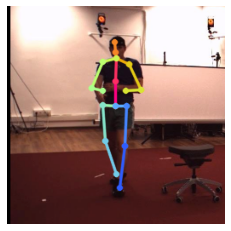

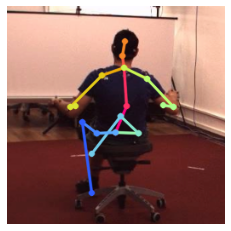

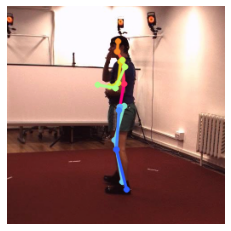

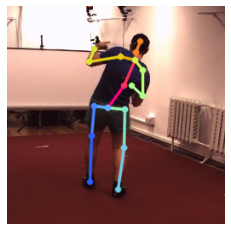

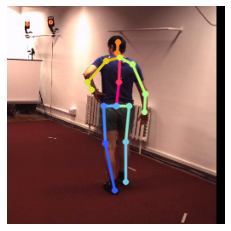

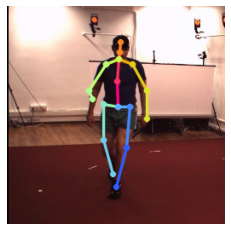

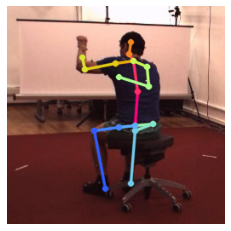

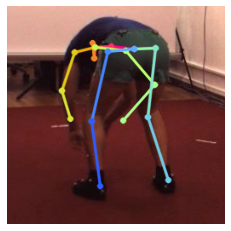

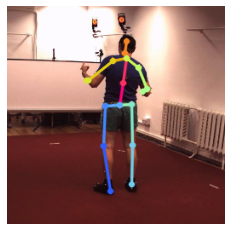

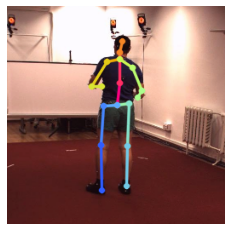

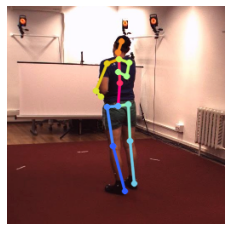

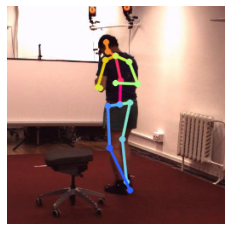

In [ ]:
cudnn.fastest = True
cudnn.benchmark = True
cudnn.deterministic = False
cudnn.enabled = True

import matplotlib.pyplot as plt
model.eval()
with torch.no_grad():
    for itr, (input_img, _) in enumerate(batch_generator):            
        # forward
        pred_coord = model(input_img)

        #visualize
        filename = str(itr)
        tmpimg = input_img[0].cpu().numpy()
        tmpimg = tmpimg * np.array([0.229, 0.224, 0.225]).reshape(3,1,1) + np.array([0.485, 0.456, 0.406]).reshape(3,1,1)
        tmpimg = tmpimg.astype(np.uint8)        
        tmpimg = np.transpose(tmpimg,(1,2,0)).copy()
        tmpkps = np.zeros((3,18))
        tmpkps[:2,:] = pred_coord[0,:,:2].cpu().numpy().transpose(1,0) *4
        tmpkps[2,:] = 1
        tmpimg = vis_keypoints(tmpimg, tmpkps)
        plt.imshow(tmpimg)
        plt.axis('off')
        plt.show()
        if itr > 10:
          break
plt.close()
        